In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv("daily_steps.csv")

In [11]:
display(df)

,date,steps
0,2022-01-03,5171
1,2022-01-04,10336
2,2022-01-05,4014
3,2022-01-06,4797
4,2022-01-07,10705
...,...,...
1089,2024-12-27,3645
1090,2024-12-28,4821
1091,2024-12-29,4014
1092,2024-12-30,4014


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [60]:
df1 = df.set_index('date')

weekly_steps = df1.resample('W').mean()
monthly_steps = df1.resample('ME').mean()
weekly_steps.head()

,steps
date,
2022-01-09,7019.142857
2022-01-16,7857.428571
2022-01-23,4140.857143
2022-01-30,4621.285714
2022-02-06,7429.000000


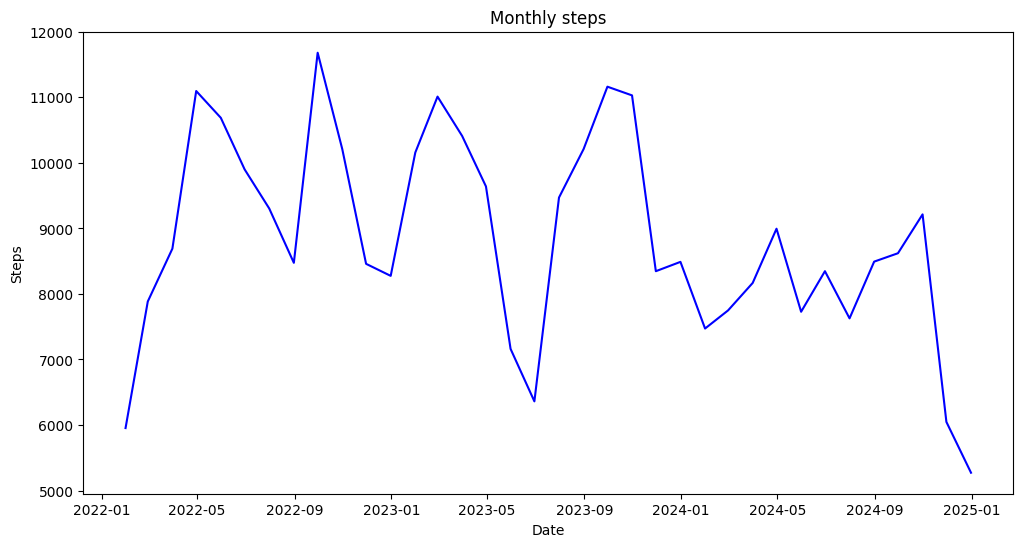

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_steps['steps'], linewidth=1.5,c='blue')
plt.title("Monthly steps")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.show()

In [21]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(weekly_steps['steps'])

ADF Statistic: -5.9168294402127035
p-value: 2.5610719061207327e-07
Stationary


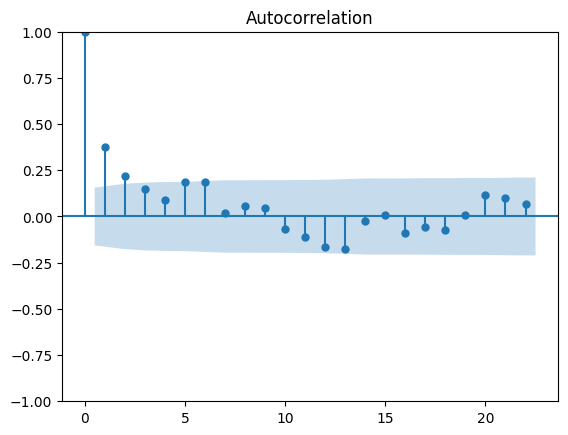

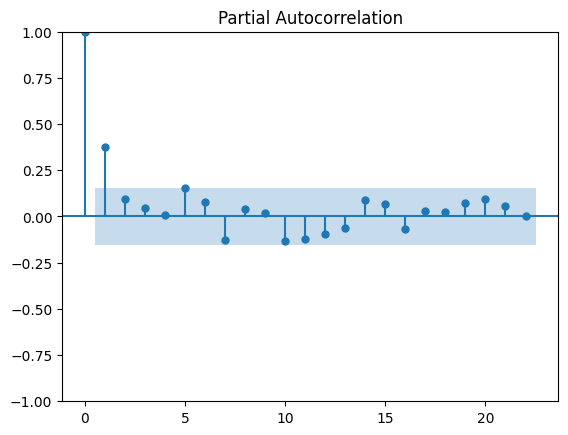

In [22]:
plot_acf(monthly_steps)
plot_pacf(monthly_steps)
plt.show()

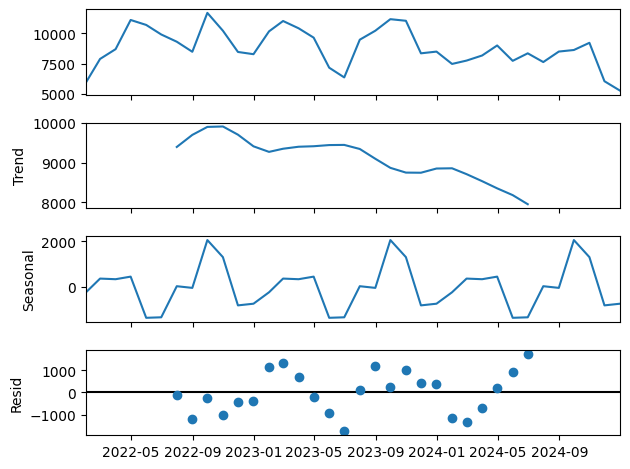

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_steps, model='additive', period=12)  # period=12 for monthly data with yearly seasonality
decomposition.plot()
plt.show()

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Run Ljung-Box test on the data, checking for seasonality. Greater than 0.05 p-value is good
ljung_box_results = acorr_ljungbox(monthly_steps, lags=[12])
print(ljung_box_results)

      lb_stat  lb_pvalue
12  17.470812   0.132729


In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
model = ExponentialSmoothing(monthly_steps['steps'], trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Generate forecast
forecast_steps = 12  # Predict 12 months ahead
forecast = results.forecast(steps=forecast_steps)

# Compute standard errors (assuming normal errors)
forecast_se = np.std(results.resid)  # Standard deviation of residuals (errors)

# Confidence interval at 95%
z_score = 1.96  # For 95% confidence
upper_bound = forecast + z_score * forecast_se
lower_bound = forecast - z_score * forecast_se

# Create DataFrame for visualization
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Upper Bound': upper_bound,
    'Lower Bound': lower_bound
})

In [47]:
display(forecast_df)

,Forecast,Upper Bound,Lower Bound
2025-01-31,5329.227799,7388.578016,3269.877582
2025-02-28,6194.433267,8253.783483,4135.083050
2025-03-31,6255.645695,8314.995912,4196.295479
2025-04-30,6931.542650,8990.892867,4872.192433
2025-05-31,5434.067390,7493.417607,3374.717173
2025-06-30,5008.370874,7067.721091,2949.020657
2025-07-31,5514.903016,7574.253232,3455.552799
2025-08-31,5685.185171,7744.535388,3625.834954
2025-09-30,7048.899473,9108.249690,4989.549256
2025-10-31,6647.369054,8706.719270,4588.018837


In [40]:
monthly_steps["Month"] = monthly_steps.index.month

# Compute the average value for each month across all previous years
monthly_avg = monthly_steps.groupby("Month")["steps"].mean()

# Generate future dates for 2025 (12 months beyond the last available date)
last_date = monthly_steps.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq="ME")

# Extract month numbers for future dates
future_months = future_dates.month

# Create 2025 forecast using the corresponding monthly averages
forecast3 = pd.DataFrame({"steps": [monthly_avg[m] for m in future_months]}, index=future_dates)

print(forecast3)

                   steps
2025-01-31   7861.299963
2025-02-28   8881.630131
2025-03-31   9089.924731
2025-04-30   9910.844444
2025-05-31   8525.903226
2025-06-30   8202.922222
2025-07-31   8800.569892
2025-08-31   9059.591398
2025-09-30  10488.277778
2025-10-31  10151.311828
2025-11-30   7618.000000
2025-12-31   7345.774194


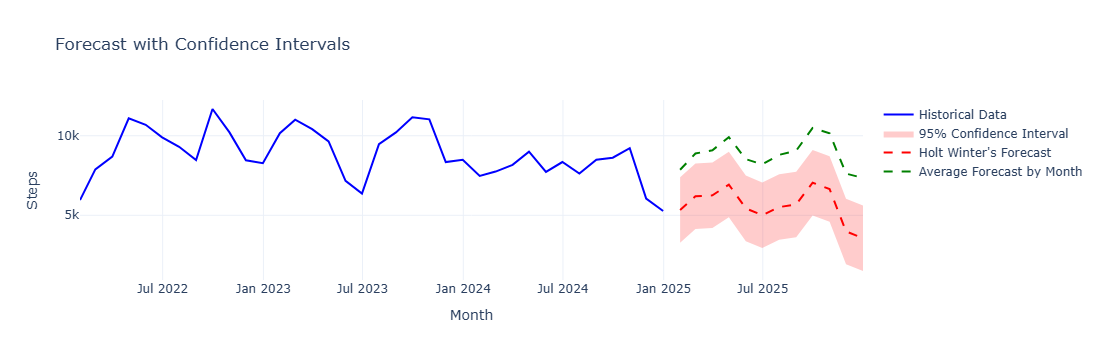

In [54]:
# Plot with Plotly
fig = go.Figure()

# Add actual data
fig.add_trace(go.Scatter(
    x=monthly_steps.index, 
    y=monthly_steps['steps'], 
    mode='lines', 
    name='Historical Data', 
    line=dict(color='blue')
))

# Add confidence intervals (shaded region)
fig.add_trace(go.Scatter(
    x=forecast.index.tolist() + forecast.index[::-1].tolist(),  # x values (forward + reversed)
    y=upper_bound.tolist() + lower_bound[::-1].tolist(),  # Upper bound then lower bound (to form a shaded area)
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',  # Transparent red
    line=dict(color='rgba(255, 255, 255, 0)'),  # No border
    name='95% Confidence Interval'
))

# Add forecast
fig.add_trace(go.Scatter(
    x=forecast.index, 
    y=forecast, 
    mode='lines', 
    name="Holt Winter's Forecast", 
    line=dict(color='red', dash='dash')
))


# Add forecasted data
fig.add_trace(go.Scatter(
    x=forecast3.index, 
    y=forecast3['steps'], 
    mode='lines', 
    name='Average Forecast by Month', 
    line=dict(color='green', dash='dash')
))

# Layout settings
fig.update_layout(
    title="Forecast with Confidence Intervals",
    xaxis_title="Month",
    yaxis_title="Steps",
    template="plotly_white"
)

fig.show()

In [56]:
## Unused

In [43]:
forecast2 = monthly_steps.shift(12)  # Creates a 1-year lag forecast for 2024

# Get the last date from monthly_steps
last_date = monthly_steps.index[-1]

# Generate future dates for 12 months beyond last_date (for 2025)
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq="ME")

# Extend the last 12 months of shifted data into 2025
future_forecast = forecast2[-12:].copy()
future_forecast.index = future_dates  # Assign new future dates

# Combine both shifted (2024) and extended (2025) forecasts
forecast2 = pd.concat([forecast2, future_forecast])

In [23]:
display(forecast2.tail())

,steps
2025-08-31,8493.161290
2025-09-30,8621.333333
2025-10-31,9214.161290
2025-11-30,6047.366667
2025-12-31,5272.032258


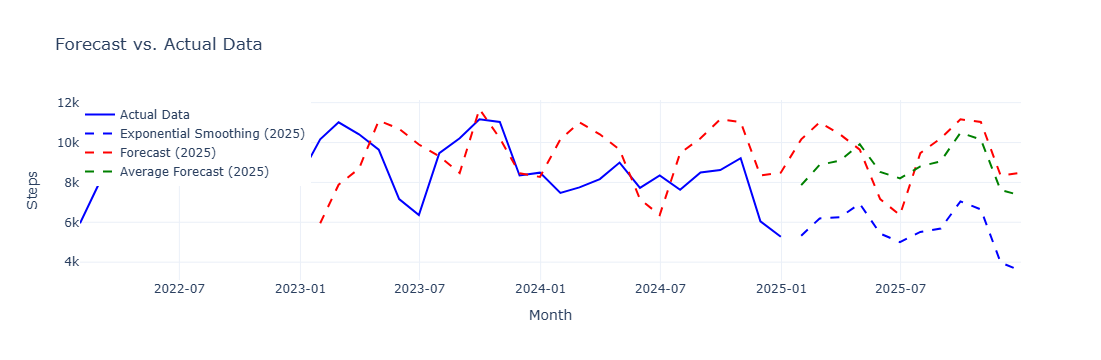

In [44]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add actual data (monthly_steps)
fig.add_trace(go.Scatter(
    x=monthly_steps.index, 
    y=monthly_steps['steps'], 
    mode='lines', 
    name='Actual Data', 
    line=dict(color='blue')
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=forecast.index, 
    y=forecast, 
    mode='lines', 
    name='Exponential Smoothing (2025)', 
    line=dict(color='blue', dash='dash')
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=forecast2.index, 
    y=forecast2['steps'], 
    mode='lines', 
    name='Forecast (2025)', 
    line=dict(color='red', dash='dash')
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=forecast3.index, 
    y=forecast3['steps'], 
    mode='lines', 
    name='Average Forecast (2025)', 
    line=dict(color='green', dash='dash')
))


# Layout settings
fig.update_layout(
    title="Forecast vs. Actual Data",
    xaxis=dict(
        title="Month",
        tickformat="%Y-%m",
        range=[monthly_steps.index.min(), forecast2.index.max()]  # Ensure 2025 is included
    ),
    xaxis_title="Month",
    yaxis_title="Steps",
    legend=dict(x=0, y=1),
    template="plotly_white"
)

# Show figure
fig.show()
